['naturalearth_cities', 'naturalearth_lowres', 'nybb']


(49.959999905, 58.6350001085)

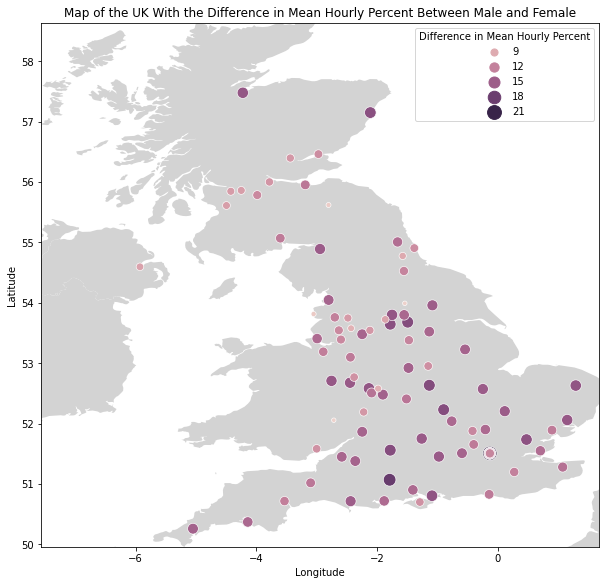

In [107]:
# Check UK Gender Pay Gap in the UK
# Datasets from:
# https://www.gov.uk/government/stat
# https://simplemaps.com/data/gb-cities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

print(gpd.datasets.available)

# Read the data
df = pd.read_csv('uk-pay-gap.csv')
post_code_to_region = pd.read_csv('postcode-area-to-name.csv')
city_to_coordinates = pd.read_csv('worldcities.csv')
city_to_coordinates_uk = city_to_coordinates[city_to_coordinates['country'] == 'United Kingdom']

pat = df["PostCode"].str.extract('([^[0-9]+)', expand = False)
grouped = df.groupby(pat)

data = grouped["DiffMeanHourlyPercent"].mean().sort_values(ascending=False)
data_filtered = data[data.index.isin(post_code_to_region["PostCode"])]
df_data = data_filtered.to_frame().merge(post_code_to_region, on="PostCode")

df_coordinates = df_data.merge(city_to_coordinates_uk, on = "city")
df_coordinates

fig, ax = plt.subplots(figsize=(10, 10))

countries = gpd.read_file("zip://./ukmap.zip")
countries.plot(color="lightgrey", ax=ax)

plt = sns.scatterplot(x = "lng", y = "lat", data = df_coordinates, size = "DiffMeanHourlyPercent", hue = "DiffMeanHourlyPercent", sizes = (20, 200), ax = ax)
plt.set_title("Map of the UK With the Difference in Mean Hourly Percent Between Male and Female")
plt.set_xlabel("Longitude")
plt.set_ylabel("Latitude")
plt.legend(title = 'Difference in Mean Hourly Percent')
plt.set_xlim(-7.57216793459, 1.68153079591)
plt.set_ylim(49.959999905, 58.6350001085)